# Model 3

In [226]:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew 

train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

train_ID = train_df['Id']
test_ID = test_df['Id']

train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)


Train_df = train_df.copy()
for column in Train_df.columns:
    if Train_df[column].dtype=='object':
        Train_df[column],unique=pd.factorize(Train_df[column])
corelation=Train_df.corrwith(Train_df['SalePrice']).sort_values(ascending=False)
corelation.head(10)


SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
dtype: float64

# Outliers

In [227]:
# removing 2 outliers
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index)

# Missing Values

In [228]:
train_df["SalePrice"] = np.log(train_df["SalePrice"])

ntrain = train_df.shape[0]
ntest = test_df.shape[0]

Y_train = train_df.SalePrice.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")




# Trasforming Features

In [229]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [230]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

In [231]:
# numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
# # Check the skew of all numerical features
# skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# print(skewness.head(10))

# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     all_data[feat] = boxcox1p(all_data[feat], lam)

In [232]:
Nulls = ['PoolQC', 'MiscFeature','Alley','Fence','FireplaceQu','LotFrontage']
all_data.drop(Nulls,axis=1,inplace=True)

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 209)


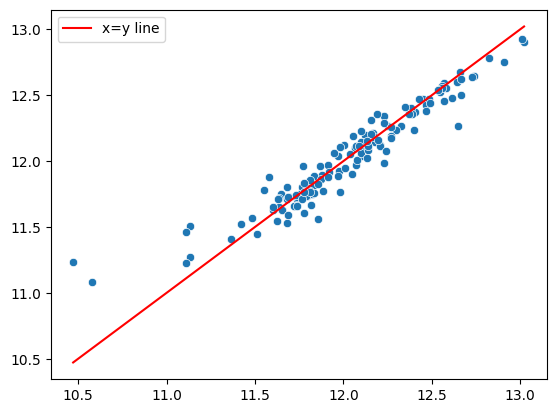

Root Mean Squared Error : 0.12772304133181195


In [233]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

final_data = all_data[:ntrain].copy()
y = Y_train
X_train, X_val, y_train, y_val =  train_test_split(final_data,y,test_size=0.1,random_state=42)
rf_regressor = make_pipeline(RobustScaler(),RandomForestRegressor(   n_estimators=100, 
                                        random_state=42,
                                        max_depth=40,
                                        min_samples_split=2,
                                        min_samples_leaf = 1,
                                        max_features = 50
                                    ))
rf_regressor.fit(X_train, y_train)
predictions = rf_regressor.predict(X_val)
mse = mean_squared_error(y_val, predictions)
# y_val = np.exp(y_val)
# predictions = np.exp(predictions)
sns.scatterplot(x=y_val, y=predictions)
min_val = min(min(y_val), min(predictions))
max_val = max(max(y_val), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='x=y line')

plt.legend()
plt.show()
print(f"Root Mean Squared Error : {mse**(0.5)}")

In [234]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=5000,
                             reg_alpha=0.52, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

X_train, X_val, y_train, y_val =  train_test_split(all_data[:ntrain],Y_train,test_size=0.1,random_state=42)
model_xgb.fit(X_train,y_train)
predictions = model_xgb.predict(X_val)
mse = mean_squared_error(predictions,y_val)

print(mse**(0.5))

# results = pd.DataFrame()
# results['Id']  = test_ID
# results['SalePrice'] = np.exp(predictions)
# results.to_csv('./data/result.csv',index=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [21:59:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


0.10102040379697076
